# Intro

Normally, the cornflakes paradigm is to put the kernel specifications into a seperate file so that they are only generated once. Multiple scripts then load the compiled result. That is, the contents of "Part 1" and "Part 2" should be in two different files. They're both together in this notebook for the sake of the discussion.

# Part 1: The Popcorn kernel

In [1]:
from popcorn import *
init_printing() # This is a Sympy method to render the equations

Note: $\mathbf{x}$ and $\mathbf{y}$ are not the axis labels, they are both points. Axes are refered to by the numbers 0,1, and 2.

In [2]:
gdim = 2
Scalar = DofSpace(1,0,2)
Vector = DofSpace(gdim,0,2)
Param  = DofSpace(1,-1)
i_x = Input('x',Vector)
i_y = Input('y',Vector)
i_k = Input('k',Param)

`Input`s are (slightly hacky) extensions of the `Matrix` class of Sympy, so you can use them directly to build symbolic expressions.

In [3]:
print i_x

Matrix([
[x[0]],
[x[1]],
[x[2]],
[x[3]]])


The `Vertex_Split` method of `Input` is a convenient way to quickly cut it up

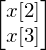

In [4]:
x0,x1 = i_x.Vertex_Split()
y0,y1 = i_y.Vertex_Split()
x1

Now that we cut up the end points of the springs, we can build useful symbolic expressions with them. Let us make expressions for the deformed and refernce length of the spring.

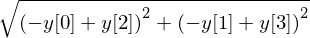

In [5]:
norm = lambda a : sqrt( (a.T*a)[0,0] )
L_defo = norm(y1-y0)
L_orig = norm(x1-x0)
L_defo

The notebook interface is paticularly useful for this type of work because it renders our equations! Imagine how useful this is to ensuring that you typed in equations correctly! Especially because we could build them symbollically, instead of having to type in vector concepts unrolled into double arrays.

The ugly [0,0] is there because 1x1 Matrices don't behave like normal Symbols in Sympy. This infuriates me, but I get why. It is just something to watch out for, and why rendering in the notebook is useful.

Now we are able to define the force between the springs,
\begin{equation}
\mathbf{f} = -k \frac{L-L_o}{L_o} \mathbf{
\end{equation}

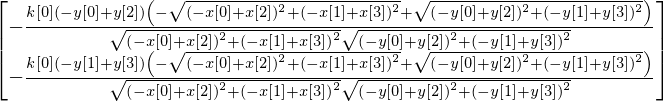

In [52]:
f = -i_k[0]*(L_defo-L_orig)/L_orig * (y1-y0)/L_defo
f

Similarly, we have to index `i_k` to get a scalar because all `PopcornVariable` types (`Input` and `Output` are children) are Matrices. (Conditional inheritance to subclass `Symbol` on length 1 variables was attempted and abandoned. There is still conditional inheritance; `PopcornVariable`s can have an unknown size based on `l_edge`, in which case it cannot be represented as a Matrix, and it needs to indexed into with `Vertex_Handle` or `__get_item__`. It supports indexing into with symbolic expressions, where it returns out a `Matrix` of fixed size.

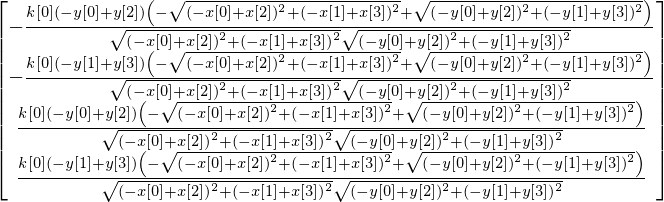

In [53]:
R = Matrix([f,-f])
R

Let's make sure we did that right...

In [8]:
R.shape

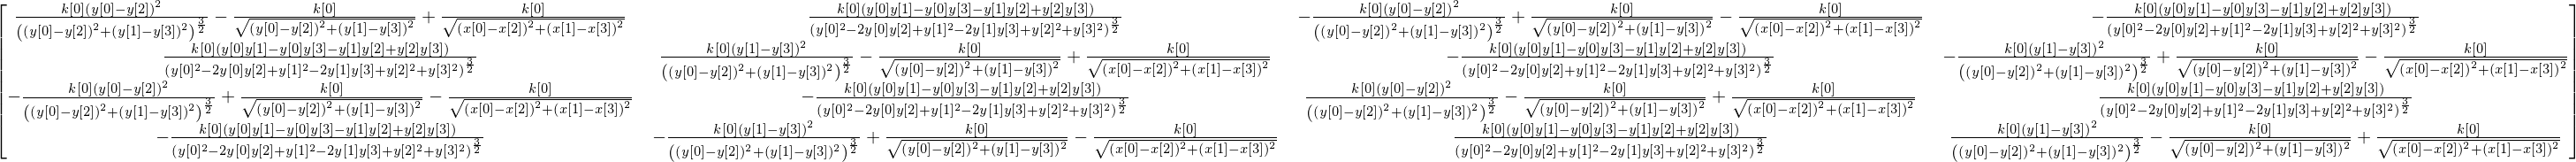

In [54]:
K = R.jacobian(i_y)
K.simplify() # This takes a long time!
K

There is a global context that manages a list of initialized Inputs, Outputs, and Kernels. Each Kernel travels the program listing to figure out which variables need to be included in the arguments, making it easy to make a whole bunch of different kernels with different arguments that share the same symbolic work.

In [55]:
o_R = Output('R',[Vector],1)
o_K = Output('K',[Vector],2)
Kernel("spring_force",
      listing=[
          Asgn(o_R,R,'='),
          Asgn(o_K,K,'=')
      ])

<popcorn.Kernel.Kernel instance at 0x10a1ff248>

The final line of a popcorn specification is the `Husk` call. $<$bad pun$>$The husk contains the kernels.$</$sorry$>$ It generates all of the C code files for all of the Kernels defined in the file and the required build system and Python wrapper.

In [56]:
# This rm line is to highlight the mechanics of it in the next section
%rm -rf husk_spring
# The final call:
Husk('spring')

# Intermezzo: the husk

The `Husk` command writes out a Python module with the name `"husk_"+argument`. There is no hidden cache or JIT runtime in cornflakes: everything is sitting in this directory that you can move around and ship with your production code. 
This design choice is to highlight a  
The popcorn file only needs to be run once and then loaded everytime you 

What's in the husk?

In [12]:
%ls husk_spring

CMakeLists.txt    kernels_spring.h  spring_force.h
__init__.py       spring_force.c    spring_swig.i


This directory contains the C files, autogenerated SWIG interface, and a CMake specification, all within the confines of a Python module. We can just import it now,

In [30]:
import husk_spring

If you look at the standard out of the notebook server, you'll see the compilation process for the husk:
```
[ 25%] Swig source
Scanning dependencies of target _spring_lib
[ 50%] Building C object CMakeFiles/_spring_lib.dir/spring_swigPYTHON_wrap.c.o
[ 75%] Building C object CMakeFiles/_spring_lib.dir/spring_force.c.o
[100%] Linking C shared module _spring_lib.so
[100%] Built target _spring_lib
```
It will only compile the first time. If the husk isn't touched, only the Built target line will be present.

In [31]:
%ls husk_spring

CMakeCache.txt            __init__.pyc              spring_force.h
CMakeFiles/               _spring_lib.so*           spring_lib.py
CMakeLists.txt            cmake_install.cmake       spring_lib.pyc
Makefile                  kernels_spring.h          spring_swig.i
__init__.py               spring_force.c            spring_swigPYTHON_wrap.c


Everything has been built for the current machine. 
You can even delete all of the files and keep only the `__init__.pyc` and `_spring_lib.so` if the containing code is sensitive. (Not every application is open source.) The original file containing the popcorn specification does not need to be included in the shipped code, either.

*Pitfall warning*: You'll have to purge it manually if you're working within, say, a Dropbox folder synced to Linux and Mac machine. It gets confused. But, it is not an issue if it copy it into a folder such as /opt/myprogram with install step and import it from there.

The generated C file is even (more or less) human readable, if we examine it by truncating the long equations:

In [40]:
!cut -c -90 husk_spring/spring_force.c

#include "spring_force.h"

#include "math.h"
#include <gsl/gsl_linalg.h>

void spring_force_eval(int l_edge,
/*Inputs:*/
const real_t * restrict y,
const real_t * restrict x,
const real_t * restrict k,
/*Outputs:*/
real_t * restrict K,
real_t * restrict R)
{
/* Evaluation of R */
R[0]= k[0]*(-y[0] + y[2])*(-sqrt(pow(-x[0] + x[2], 2) + pow(-x[1] + x[3], 2)) + sqrt(pow(-
R[1]= k[0]*(-y[1] + y[3])*(-sqrt(pow(-x[0] + x[2], 2) + pow(-x[1] + x[3], 2)) + sqrt(pow(-
R[2]= -k[0]*(-y[0] + y[2])*(-sqrt(pow(-x[0] + x[2], 2) + pow(-x[1] + x[3], 2)) + sqrt(pow(
R[3]= -k[0]*(-y[1] + y[3])*(-sqrt(pow(-x[0] + x[2], 2) + pow(-x[1] + x[3], 2)) + sqrt(pow(

/* Evaluation of K */
K[0]= -k[0]*pow(y[0] - y[2], 2)/pow(pow(y[0] - y[2], 2) + pow(y[1] - y[3], 2), 3.0L/2.0L) 
K[1]= -k[0]*(y[0]*y[1] - y[0]*y[3] - y[1]*y[2] + y[2]*y[3])/pow(pow(y[0], 2) - 2*y[0]*y[2]
K[2]= k[0]*pow(y[0] - y[2], 2)/pow(pow(y[0] - y[2], 2) + pow(y[1] - y[3], 2), 3.0L/2.0L) -
K[3]= k[0]*(y[0]*y[1] - y[0]*y[3] - y[1]*y[2] + y[2]*y[3])/

The file is two parts: 1) The generated C function, `spring_force_eval`, and 2) the kernel struct that is its call signature for cornflakes. The generated C function is self explanatory to call; all of the inputs and outputs are just pointers to `real_t`s (which is a `typedef` to `double` by default).

**It's possible to call the generated C function by itself without using cornflakes!** In that sense, popcorn can be used to help generate code for existing software without having to completely switch mindsets to use cornflakes.

Don't read much into the phrase "human-readable". In Stone, an LBNL geomechanics code linked to TOUGH+, some of the kernel C files are up to 2MB! This is on par with the size of the C++ classes that FEniCS's ffc can generate. The whole reason for pursuing Python-based code generation is that actually programming C or Fortran code for some of the equations we encounter isn't even humanly tractable!

The user has no reason to ever look at any of these files (unlike myself, who spends a lot of time looking at these to debug them). It is possible to directly inject C code into the function from the Python specification, which may merit a double-check to make sure it looks right. This husk directory can be treated as a block box that can be moved around, copied from system to system, and imported by the actual calculation in Python.

# Part 2: Cornflakes

In [57]:
import cornflakes as cf
import numpy as np

The husk containing our kernels is an importable module.

In [58]:
import husk_spring

Even though cornflakes doesn't care about the geometry, it still provides some basic helper functions for building up geometries, since that's probably what you want to do with it.

In [84]:
x = cf.PP.init_grid(10,10,[0,0],[1,0],[0,1])
y = x
H = cf.Graphers.Build_Pair_Graph(x,0.2)

Let's take a look at the first 10 entries in the graph:

In [85]:
H.view()[0][10:20]

array([[ 2, 13],
       [ 3, 12],
       [ 3, 14],
       [ 3, 13],
       [ 4,  3],
       [ 4,  5],
       [ 4, 14],
       [ 4, 13],
       [ 4, 15],
       [ 5, 14]], dtype=int32)

The data keys and the Inputs of the kernel **must** have the same values. Don't worry if you are mixing and matching kernels, though; it's possible to reference the same arrays in different data dicts with different names. Cornflakes doesn't force you to organize your data a certain way, you get to tell cornflakes where it is! The data array is just an argument list; it can be inlined in the `Assemble` call, but it's often good practice to declare once and keep a consistent variable naming scheme everywhere.

In [61]:
dm_scalar = cf.Dofmap_Strided(1)
dm_vector = cf.Dofmap_Strided(2)
data = {
    'x':(x,dm_vector),
    'y':(y,dm_vector),
    'k':(np.array([1.0]),dm_scalar)
}

In [62]:
dm_vector.Get(2)

array([4, 5], dtype=int32)

In [63]:
dm_scalar.Get(2)

array([2], dtype=int32)

There's also `Dofmap_Tabled` for using a lookup table on the hypervertex id.

In [87]:
K,R = cf.Assemble2(husk_spring.kernel_spring_force,
                   H,data,
                   {'R':(dm_vector,),'K':(dm_vector,)},
                   ndof=x.size)

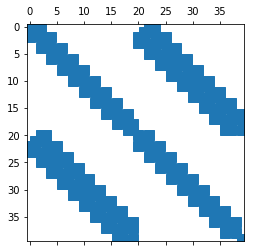

In [88]:
from matplotlib import pylab as plt
plt.spy(K[0:40,0:40])
plt.show()

Now, we want some boundary conditions. 

In [89]:
# Bottom dirrichlet BCs
marked_bot = cf.select_nodes(x, lambda a:a[1]<0.0001)
bcdofs = dm_vector.Get_List(marked_bot)
bcvals = np.zeros(bcdofs.shape,dtype=np.double)
cf.Apply_BC(bcdofs,bcvals,  K,R)
# Top loaded BCs
marked_top = cf.select_nodes(x, lambda a:a[1]>1.0-0.0001)
loaddofs = dm_vector.Get_List(marked_top).reshape(len(marked_top),2)[:,1] # Just the x's
R[loaddofs] -= 200.0
# Solve the system
import scipy.sparse.linalg as splin
u = splin.spsolve(K,R)
u = u.reshape(x.shape) # it comes out flat

array([[   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [  14.15958943,   18.66705459],
       [   8.12867666,   14.23092049],
       [   4.96987532,   13.27202881],
       [   2.7582318 ,   12.91773139],
       [   0.88858791,   12.79826726],
       [  -0.88858791,   12.79826726],
       [  -2.7582318 ,   12.91773139],
       [  -4.96987532,   13.27202881],
       [  -8.12867666,   14.23092049],
       [ -14.15958943,   18.66705459],
       [  21.03476028,   34.4904556 ],
       [  14.92796115,   30.44921498],
       [   9.58979446,   28.25704966],
       [   5.37636641,   27.34542181],
       [   1.73549675,   26.99736459],
       [  -1.73549675,   

# Outro

This was the simplest possible model. The next set of examples will demonstrate the full capabilities of popcorn and cornflakes.